# Deep Learning Hello World

Basic examples for Tensorflow, Pytorch and JAX-based neural networks

In [54]:
import numpy as np
import pandas as pd
import copy
from collections import defaultdict
from matplotlib import pyplot as plt
from tabulate import tabulate
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor, LGBMClassifier

import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader
import jax
from jax import numpy as jnp
from jax import jit as jjit
import haiku as hk

In [2]:
# Limit Tensorflow GPU memory usage
gpu_devices = tf.config.list_physical_devices('GPU')
print(gpu_devices)
if len(gpu_devices) > 0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Feedforward 1: Linear Regression
(Training and variance of a very simple regression model)

- 1 hidden layer with ReLU activation
- MSE loss
- SGD optimization
- No minibatch (all data per batch)

In [3]:
n = 100
p = 3
train_rate = 0.7

X = np.random.normal(0, 1, size=(n, p))
y = np.sum(X, axis=1) + np.random.normal(0, 0.5, size=n)
print(tabulate(X[-3:], floatfmt='.4f'))
print(tabulate(y[-3:, np.newaxis], floatfmt='.4f'))

n_train = int(n*train_rate)

X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

-------  -------  -------
 0.9403  -1.1276   0.9768
-0.0029  -0.7202  -0.8220
 0.1518  -0.8361  -1.2368
-------  -------  -------
-------
 0.5787
-1.1277
-2.4827
-------


## Baseline: Linear Regression

In [4]:
model = LinearRegression()
model.fit(X_train, y_train)
print(f'Train {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

Train 0.542
Test  0.517


## TF2

- https://www.tensorflow.org/tutorials/keras/regression
- https://www.tensorflow.org/guide/keras/train_and_evaluate

In [5]:
def init_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(p, activation='relu', input_shape=(p,)),
        tf.keras.layers.Dense(1),
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.SGD(0.01),
        metrics=['mae', 'mse'],
    )
    
    return model

model = init_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


CPU times: user 15.1 s, sys: 1.33 s, total: 16.5 s
Wall time: 12.9 s


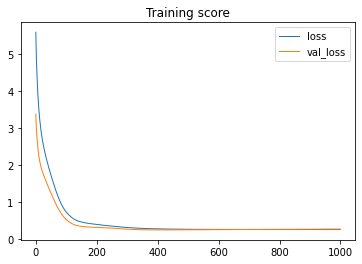

In [6]:
%%time
train_history = model.fit(
    X_train, 
    y_train,
    batch_size=n,
    epochs=1000, 
    validation_split=0.2, 
    verbose=0,
)
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)

In [7]:
print(f'Train loss {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test loss  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

Train loss 0.519
Test loss  0.515


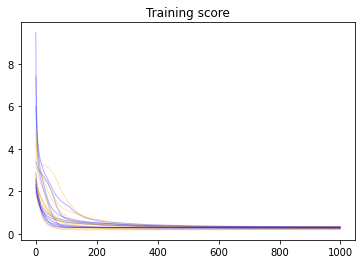

In [8]:
# Model variance
fig, ax = plt.subplots()

for i in range(10):
    model = init_model()

    train_history = model.fit(
        X_train, 
        y_train,
        epochs=1000, 
        validation_split=0.2, 
        verbose=0,
    )
    _ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(
        title='Training score', lw=1, ax=ax, 
        legend=False, color=['blue', 'orange'], alpha=0.3,
    )

## PyTorch


https://towardsdatascience.com/pytorch-tabular-regression-428e9c9ac93

In [9]:
def init_model():
    model = torch.nn.Sequential(
        torch.nn.Linear(p, p),
        torch.nn.ReLU(),
        torch.nn.Linear(p, 1),
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_func = torch.nn.MSELoss()
    
    return model, optimizer, loss_func

model, optimizer, loss_func = init_model()

print(model)

Sequential(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
)


CPU times: user 378 ms, sys: 12.3 ms, total: 390 ms
Wall time: 384 ms


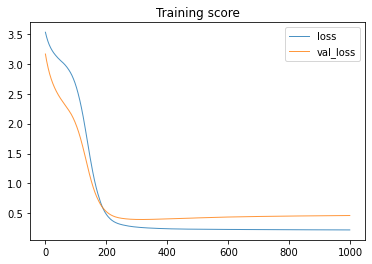

In [10]:
%%time
train_history = defaultdict(list)
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, train_size=0.8)
inputs = torch.from_numpy(X_train_1).float()
outputs = torch.from_numpy(y_train_1[:, np.newaxis]).float()
val_inputs = torch.from_numpy(X_train_2).float()
val_outputs = torch.from_numpy(y_train_2[:, np.newaxis]).float()

for epoch in range(1000):
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs_hat = model(inputs)
    loss = loss_func(outputs_hat, outputs)
    loss.backward()
    optimizer.step()
    
    # save training loss
    train_history['loss'].append(loss.item())
    
    # compute validation loss
    with torch.no_grad():
        val_outputs_hat = model(val_inputs)
        val_loss = loss_func(val_outputs_hat, val_outputs)
        train_history['val_loss'].append(val_loss.item())

_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)

In [11]:
print(f'Train {np.sqrt(mean_squared_error(y_train, model(torch.from_numpy(X_train).float()).detach().numpy())):.3f}')
print(f'Test  {np.sqrt(mean_squared_error(y_test, model(torch.from_numpy(X_test).float()).detach().numpy())):.3f}')

Train 0.519
Test  0.622


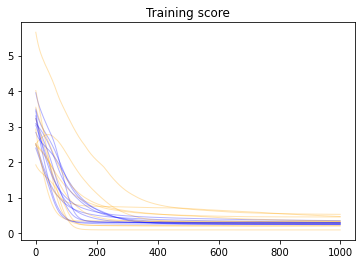

In [12]:
# Model variance
fig, ax = plt.subplots()

for i in range(10):
    model, optimizer, loss_func = init_model()
    
    train_history = defaultdict(list)
    X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, train_size=0.8)
    inputs = torch.from_numpy(X_train_1).float()
    outputs = torch.from_numpy(y_train_1[:, np.newaxis]).float()
    val_inputs = torch.from_numpy(X_train_2).float()
    val_outputs = torch.from_numpy(y_train_2[:, np.newaxis]).float()
    for epoch in range(1000):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs_hat = model(inputs)
        loss = loss_func(outputs_hat, outputs)
        loss.backward()
        optimizer.step()

        # save training loss
        train_history['loss'].append(loss.item())

        # compute validation loss
        with torch.no_grad():
            val_outputs_hat = model(val_inputs)
            val_loss = loss_func(val_outputs_hat, val_outputs)
            train_history['val_loss'].append(val_loss.item())
    
    _ = pd.DataFrame(train_history)[['loss', 'val_loss']].plot(
        title='Training score', lw=1, ax=ax, 
        legend=False, color=['blue', 'orange'], alpha=0.3,
    )
    

## Haiku

- https://github.com/deepmind/dm-haiku
- https://github.com/deepmind/dm-haiku/blob/master/examples/mnist.py

In [13]:
@jjit
def mse(outputs, outputs_hat):
    return (outputs-outputs_hat)**2

# @jjit
def loss_fn(inputs, outputs):
    mlp = hk.Sequential([
        hk.Linear(p), 
        jax.nn.relu,
        hk.Linear(1),
    ])
    outputs_hat = mlp(inputs)
    return jnp.mean(jnp.mean(mse(outputs, outputs_hat)))

# hk.transform allows us to turn this function into a pair of pure functions: init and apply. 
# All JAX transformations require to pass in a pure function for correct behaviour.
# Haiku makes it easy to write them.
loss_obj = hk.transform(loss_fn, apply_rng=True)

# Initial parameter values are typically random. In JAX you need a key in order
# to generate random numbers and so Haiku requires you to pass one in.
rng = jax.random.PRNGKey(42)

# `init` runs your function, as such we need an example input. Typically you can
# pass "dummy" inputs (e.g. ones of the same shape and dtype) since initialization
# is not usually data dependent.
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, train_size=0.8)
X_train_1_ = jnp.asarray(X_train_1)
y_train_1_ = jnp.asarray(y_train_1[:, np.newaxis])
X_train_2_ = jnp.asarray(X_train_2)
y_train_2_ = jnp.asarray(y_train_2[:, np.newaxis])
X_test_ = jnp.asarray(X_test)
y_test_ = jnp.asarray(y_test[:, np.newaxis])

# The result of `init` is a nested data structure of all the parameters in your
# network. You can pass this into `apply`.
params = loss_obj.init(rng, X_train_1_, y_train_1_)
print(params)

# Gradient update
@jjit
def sgd(param, update):
    return param - 0.01 * update

/home/nameless/dev/vfenv/ds/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


frozendict({
  'linear': frozendict({
              'b': DeviceArray([0., 0., 0.], dtype=float32),
              'w': DeviceArray([[-0.85853237,  0.12908897, -0.13488792],
                                [ 0.24561784, -0.20738742,  0.15554754],
                                [-0.06070174,  0.3124922 ,  0.18682341]], dtype=float32),
            }),
  'linear_1': frozendict({
                'b': DeviceArray([0.], dtype=float32),
                'w': DeviceArray([[ 0.37143728],
                                  [-0.6535752 ],
                                  [ 0.5136476 ]], dtype=float32),
              }),
})


CPU times: user 11.2 s, sys: 971 ms, total: 12.2 s
Wall time: 9.6 s


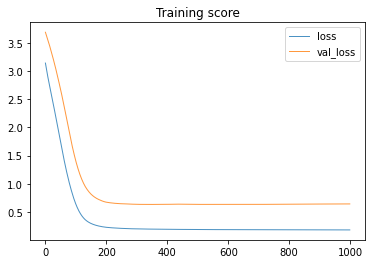

In [14]:
%%time

train_history = defaultdict(list)
for epoch in range(1000):
    # The `apply` function allows you to inject parameter values into your function.
#     grads = jax.grad(loss_obj.apply)(params, None, X_train_, y_train_)
#     loss = loss_obj.apply(params, None, X_train_, y_train_)
    loss, grads = jax.value_and_grad(loss_obj.apply)(params, None, X_train_1_, y_train_1_)
    params = jax.tree_multimap(sgd, params, grads)
    
    # Record train loss
    loss = float(jax.device_get(loss))
    train_history['loss'].append(loss)
    
    val_loss = loss_obj.apply(params, None, X_train_2_, y_train_2_)
    val_loss = float(jax.device_get(val_loss))
    train_history['val_loss'].append(val_loss)
    
_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)

In [15]:
print(f'Train loss {np.sqrt(loss_obj.apply(params, None, X_train_1_, y_train_1_)):.3f}')
print(f'Test loss  {np.sqrt(loss_obj.apply(params, None, X_test_, y_test_)):.3f}')

Train loss 0.423
Test loss  0.647


In [16]:
# Model variance
# TODO

## Flax

https://github.com/google/flax

In [17]:
# TODO

# Feedforward 2: Non-linear Regression
(Minibatch and its impact on training speed)

- 2 hidden layers with ReLU activation
- MSE loss
- SGD optimization
- Minibatch (10/100/1000/10000 samples)

In [18]:
n = 10000
p = 3
train_rate = 0.7

X = np.random.normal(0, 1, size=(n, p))
y = np.sum(X[:, :-2] * X[:, 1:-1], axis=1)  + np.random.normal(0, 0.5, size=n)
print(tabulate(X[-3:], floatfmt='.4f'))
print(tabulate(y[-3:, np.newaxis], floatfmt='.4f'))

n_train = int(n*train_rate)

X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

-------  -------  -------
 0.4074   1.0009   0.3860
-0.2811  -1.6573  -0.1362
-0.5307  -0.3207   1.6674
-------  -------  -------
------
0.7382
0.9666
0.9338
------


## Baseline: Gradient Boosting

In [19]:
model = LGBMRegressor(
    n_estimators=1000, 
    min_data_in_leaf=10,
    learning_rate=0.01,
    objective='regression',
)

model.fit(X_train, y_train)
print(f'Train loss {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test loss  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

Train loss 0.453
Test loss  0.523


## TF2

Train loss 0.512
Test loss  0.519
CPU times: user 12min 33s, sys: 1min 13s, total: 13min 46s
Wall time: 7min 26s


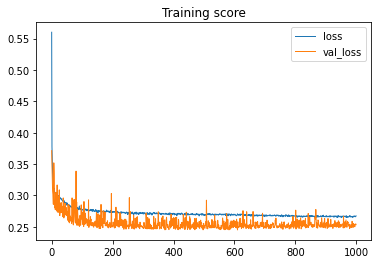

In [20]:
%%time

def train_model(X_train, y_train, batch_size):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(7, activation='relu', input_shape=(p,)),
        tf.keras.layers.Dense(7, activation='relu'),
        tf.keras.layers.Dense(1),
    ])

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.SGD(0.01),
        metrics=['mae', 'mse'],
    )

    train_history = model.fit(
        X_train, 
        y_train,
        batch_size=batch_size,
        epochs=1000, 
        validation_split=0.2, 
        verbose=0,
    )
    return model, train_history

# batch size = 10
model, train_history = train_model(X_train, y_train, batch_size=10)
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train loss {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test loss  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

Train loss 0.507
Test loss  0.517
CPU times: user 1min 42s, sys: 9.83 s, total: 1min 51s
Wall time: 1min 5s


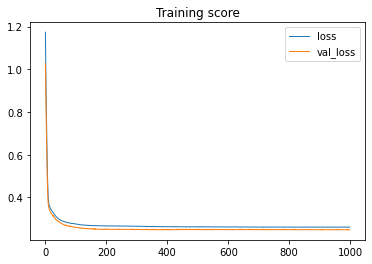

In [21]:
%%time
# batch size = 100
model, train_history = train_model(X_train, y_train, batch_size=100)
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train loss {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test loss  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

Train loss 0.519
Test loss  0.535
CPU times: user 24.1 s, sys: 2.25 s, total: 26.4 s
Wall time: 17 s


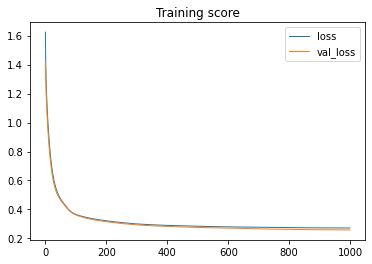

In [22]:
%%time
# batch size = 1000
model, train_history = train_model(X_train, y_train, batch_size=1000)
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train loss {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test loss  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

Train loss 0.868
Test loss  0.884
CPU times: user 15.5 s, sys: 1.09 s, total: 16.5 s
Wall time: 12.5 s


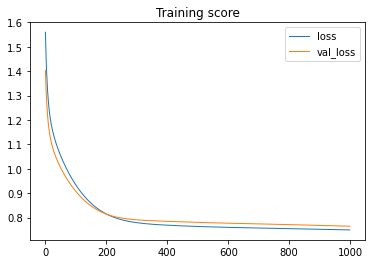

In [23]:
%%time
# batch size = 10000
model, train_history = train_model(X_train, y_train, batch_size=10000)
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train loss {np.sqrt(mean_squared_error(y_train, model.predict(X_train))):.3f}')
print(f'Test loss  {np.sqrt(mean_squared_error(y_test, model.predict(X_test))):.3f}')

## PyTorch

In [24]:
class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            X = torch.from_numpy(X).float()
        if not torch.is_tensor(y):
            y = torch.from_numpy(y[:, np.newaxis]).float()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Train 0.507
Test  0.514
CPU times: user 3min 48s, sys: 2.6 s, total: 3min 50s
Wall time: 3min 48s


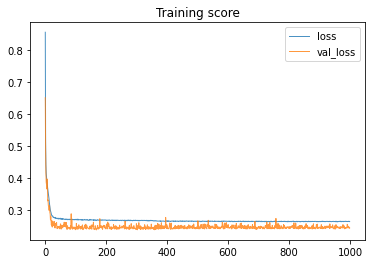

In [25]:
%%time

def train_model(X_train, y_train, batch_size):
    model = torch.nn.Sequential(
        torch.nn.Linear(p, 7),
        torch.nn.ReLU(),
        torch.nn.Linear(7, 7),
        torch.nn.ReLU(),
        torch.nn.Linear(7, 1),
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_func = torch.nn.MSELoss()

    X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, train_size=0.8)
    train_loader = DataLoader(PrepareData(X_train_1, y=y_train_1), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(PrepareData(X_train_2, y=y_train_2), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(PrepareData(X_test, y=y_test), batch_size=batch_size, shuffle=True)
    train_history = defaultdict(list)
    
    for epoch in range(1000):
        loss_c = 0
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()
            y_train_batch_hat = model(X_train_batch)
            loss = loss_func(y_train_batch_hat, y_train_batch)
            loss.backward()
            optimizer.step()
            loss_c += loss.item()
        train_history['loss'].append(loss_c/len(train_loader))

        with torch.no_grad():
            val_loss_c = 0
            for X_val_batch, y_val_batch in val_loader:
                y_val_batch_hat = model(X_val_batch)
                val_loss = loss_func(y_val_batch_hat, y_val_batch)
                val_loss_c += val_loss.item()
            train_history['val_loss'].append(val_loss_c/len(val_loader))
    return model, train_history

# batch size = 10
model, train_history = train_model(X_train, y_train, batch_size=10)
_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)
print(f'Train {np.sqrt(mean_squared_error(y_train, model(torch.from_numpy(X_train).float()).detach().numpy())):.3f}')
print(f'Test  {np.sqrt(mean_squared_error(y_test, model(torch.from_numpy(X_test).float()).detach().numpy())):.3f}')

Train 0.510
Test  0.518
CPU times: user 48.7 s, sys: 78.1 ms, total: 48.8 s
Wall time: 48.6 s


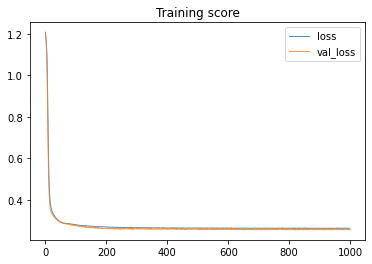

In [26]:
%%time
# batch size = 100
model, train_history = train_model(X_train, y_train, batch_size=100)
_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)
print(f'Train {np.sqrt(mean_squared_error(y_train, model(torch.from_numpy(X_train).float()).detach().numpy())):.3f}')
print(f'Test  {np.sqrt(mean_squared_error(y_test, model(torch.from_numpy(X_test).float()).detach().numpy())):.3f}')

Train 0.522
Test  0.533
CPU times: user 3min 24s, sys: 0 ns, total: 3min 24s
Wall time: 37.2 s


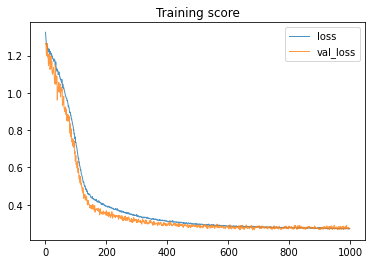

In [27]:
%%time
# batch size = 1000
model, train_history = train_model(X_train, y_train, batch_size=1000)
_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)
print(f'Train {np.sqrt(mean_squared_error(y_train, model(torch.from_numpy(X_train).float()).detach().numpy())):.3f}')
print(f'Test  {np.sqrt(mean_squared_error(y_test, model(torch.from_numpy(X_test).float()).detach().numpy())):.3f}')

Train 0.890
Test  0.911
CPU times: user 2min 50s, sys: 0 ns, total: 2min 50s
Wall time: 49.4 s


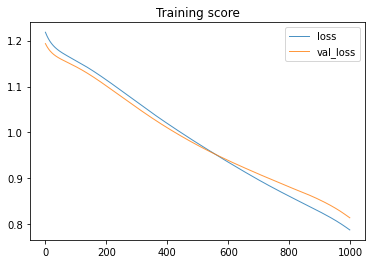

In [28]:
%%time
# batch size = 10000
model, train_history = train_model(X_train, y_train, batch_size=10000)
_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)
print(f'Train {np.sqrt(mean_squared_error(y_train, model(torch.from_numpy(X_train).float()).detach().numpy())):.3f}')
print(f'Test  {np.sqrt(mean_squared_error(y_test, model(torch.from_numpy(X_test).float()).detach().numpy())):.3f}')

# Feedforward 3: Binary Classification
(MSE vs Cross-entropy for classification)

- 2 hidden layers with ReLU activation
- sigmoid output
- Cross-entropy / MSE loss
- SGD optimization
- Minibatch (100 samples)

In [29]:
n = 10000
p = 3
train_rate = 0.7

X = np.random.normal(0, 1, size=(n, p))
y = np.sum(X[:, :-2] * X[:, 1:-1], axis=1)  + np.random.normal(0, 0.5, size=n)
y = (y > 0).astype(float)
print(tabulate(X[-3:], floatfmt='.4f'))
print(tabulate(y[-3:, np.newaxis], floatfmt='.4f'))

n_train = int(n*train_rate)

X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

-------  -------  -------
 1.2785   0.6860  -0.4660
-0.6291   0.7260  -0.2380
-0.8578  -0.4658  -1.4533
-------  -------  -------
------
1.0000
0.0000
1.0000
------


## Baseline: Gradient Boosting

In [30]:
model = LGBMClassifier(
    n_estimators=1000, 
    min_data_in_leaf=10,
    learning_rate=0.01,
    objective='cross_entropy',
)

model.fit(X_train, y_train)
print(f'Train score {accuracy_score(y_train, model.predict(X_train)):.3f}')
print(f'Test score  {accuracy_score(y_test, model.predict(X_test)):.3f}')

Train score 0.848
Test score  0.758


## TF2

https://www.tensorflow.org/tutorials/keras/classification

Train score 0.773
Test score  0.768
CPU times: user 2min 3s, sys: 7.95 s, total: 2min 11s
Wall time: 1min 19s


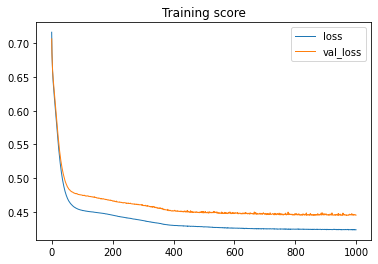

In [31]:
%%time

def train_model(X_train, y_train, loss, activation):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(7, activation='relu', input_shape=(p,)),
        tf.keras.layers.Dense(7, activation='relu'),
        tf.keras.layers.Dense(1, activation=activation),
    ])

    model.compile(
        loss=loss,
        optimizer=tf.keras.optimizers.SGD(0.01),
        metrics=['accuracy'],
    )

    train_history = model.fit(
        X_train, 
        y_train,
        batch_size=100,
        epochs=1000, 
        validation_split=0.2, 
        verbose=0,
    )
    return model, train_history

# cross-entropy + sigmoid
def decide(arr):
    return (arr > 0.5).astype(float)

model, train_history = train_model(X_train, y_train, loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), activation='sigmoid')
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train score {accuracy_score(y_train, decide(model.predict(X_train))):.3f}')
print(f'Test score  {accuracy_score(y_test, decide(model.predict(X_test))):.3f}')

Train score 0.776
Test score  0.766
CPU times: user 2min 2s, sys: 11.1 s, total: 2min 13s
Wall time: 1min 20s


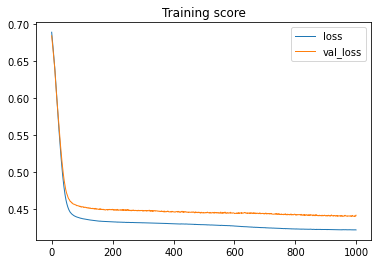

In [32]:
%%time

# cross-entropy (logits=True) + linear
# (more stable numerically)
def decide(arr):
    return (arr > 0.).astype(float)

model, train_history = train_model(X_train, y_train, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), activation='linear')
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train score {accuracy_score(y_train, decide(model.predict(X_train))):.3f}')
print(f'Test score  {accuracy_score(y_test, decide(model.predict(X_test))):.3f}')

Train score 0.776
Test score  0.768
CPU times: user 1min 43s, sys: 9.5 s, total: 1min 52s
Wall time: 1min 5s


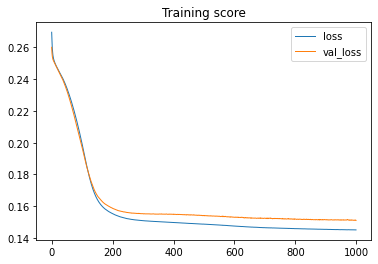

In [33]:
%%time

# mse + sigmoid
def decide(arr):
    return (arr > 0.5).astype(float)

model, train_history = train_model(X_train, y_train, loss='mse', activation='sigmoid')
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train score {accuracy_score(y_train, decide(model.predict(X_train))):.3f}')
print(f'Test score  {accuracy_score(y_test, decide(model.predict(X_test))):.3f}')

Train score 0.551
Test score  0.547
CPU times: user 1min 42s, sys: 9.93 s, total: 1min 52s
Wall time: 1min 5s


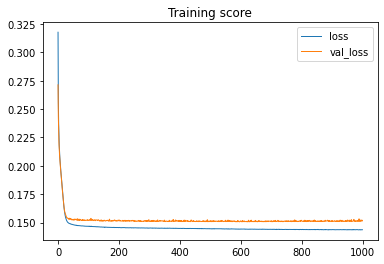

In [34]:
%%time

# mse + linear
def decide(arr):
    return (arr > 0.).astype(float)

model, train_history = train_model(X_train, y_train, loss='mse', activation='linear')
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
print(f'Train score {accuracy_score(y_train, decide(model.predict(X_train))):.3f}')
print(f'Test score  {accuracy_score(y_test, decide(model.predict(X_test))):.3f}')

## PyTorch

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [35]:
class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            X = torch.from_numpy(X).float()
        if not torch.is_tensor(y):
            y = torch.from_numpy(y[:, np.newaxis]).float()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Train 0.777
Test  0.770
CPU times: user 49.7 s, sys: 355 ms, total: 50.1 s
Wall time: 49.8 s


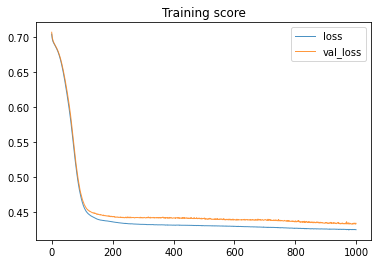

In [36]:
%%time
def train_model(X_train, y_train):
    model = torch.nn.Sequential(
        torch.nn.Linear(p, 7),
        torch.nn.ReLU(),
        torch.nn.Linear(7, 7),
        torch.nn.ReLU(),
        torch.nn.Linear(7, 1),
        torch.nn.Sigmoid(),
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_func = torch.nn.BCELoss()

    X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, train_size=0.8)
    train_loader = DataLoader(PrepareData(X_train_1, y=y_train_1), batch_size=100, shuffle=True)
    val_loader = DataLoader(PrepareData(X_train_2, y=y_train_2), batch_size=100, shuffle=True)
    test_loader = DataLoader(PrepareData(X_test, y=y_test), batch_size=100, shuffle=True)
    train_history = defaultdict(list)
    
    for epoch in range(1000):
        loss_c = 0
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()
            y_train_batch_hat = model(X_train_batch)
            loss = loss_func(y_train_batch_hat, y_train_batch)
            loss.backward()
            optimizer.step()
            loss_c += loss.item()
        train_history['loss'].append(loss_c/len(train_loader))

        with torch.no_grad():
            val_loss_c = 0
            for X_val_batch, y_val_batch in val_loader:
                y_val_batch_hat = model(X_val_batch)
                val_loss = loss_func(y_val_batch_hat, y_val_batch)
                val_loss_c += val_loss.item()
            train_history['val_loss'].append(val_loss_c/len(val_loader))
    return model, train_history

def decide(arr):
    return (arr > 0.5).astype(float)

# cross-entropy + linear
# cross-entropy expects logits, not probabilities
model, train_history = train_model(X_train, y_train)
_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)
print(f'Train {accuracy_score(y_train, decide(model(torch.from_numpy(X_train).float()).detach().numpy())):.3f}')
print(f'Test  {accuracy_score(y_test, decide(model(torch.from_numpy(X_test).float()).detach().numpy())):.3f}')

# Feedforward 4.1: Complex Multiclass Classification
(Training on GPU)

- 3 hidden layers with ReLU activation
- Softmax output
- Cross-entropy
- SGD optimization
- Minibatch (128 samples)
- Training on CPU / GPU

------  -------  ------  -------  -------  -------  -------
1.2278  -0.7554  0.0178  -0.5981  -0.6212  -8.5453  -5.7130
0.8571   0.0364  0.9307   0.8095  -2.8233   7.3588  -7.5385
0.2808  -0.4446  0.7818  -0.1807  -0.3231   3.4082   6.4375
------  -------  ------  -------  -------  -------  -------
-
3
0
1
-
Bayes score 0.888


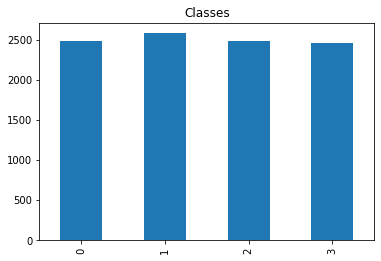

In [13]:
n = 10000
p = 7
train_rate = 0.7

def f1(X):
    h = (
        0.5 * X[:, 0] + 
        np.abs(X[:, 1]) - np.abs(X[:, 2]) +
        np.abs(X[:, 3]) * np.sign(X[:, -1]) + 
        0.5 * np.sum(X[:, :-3] * X[:, 1:-2], axis=1) + 
        2 * np.sin(X[:, -2]) * np.arctan(X[:, -1]) +
        np.prod(X[:, :4], axis=1) * np.exp(X[:, 3])
    )
    return h

def f2(h):
    return (h > -2).astype(int) + (h > 0).astype(int) + (h > 2).astype(int)

X = np.random.normal(0, (1., 1., 1., 1., 1., 5., 10.), size=(n, p))
y = f1(X) + np.random.normal(0, 0.4, size=n)
y = f2(y)
print(tabulate(X[-3:], floatfmt='.4f'))
print(tabulate(y[-3:, np.newaxis]))

n_train = int(n*train_rate)

X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

_ = pd.Series(y).value_counts(sort=False).plot(kind='bar', title='Classes')
print(f'Bayes score {accuracy_score(y, f2(f1(X))):.3f}')

## Baseline: Gradient Boosting

In [39]:
%%time

model = LGBMClassifier(
    n_estimators=1000, 
    min_data_in_leaf=10,
    learning_rate=0.01,
    objective='cross_entropy',
)

model.fit(X_train, y_train)
print(f'Train score {accuracy_score(y_train, model.predict(X_train)):.3f}')
print(f'Test score  {accuracy_score(y_test, model.predict(X_test)):.3f}')

Train score 0.925
Test score  0.673
CPU times: user 42.5 s, sys: 0 ns, total: 42.5 s
Wall time: 3.59 s


## TF2

In [40]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Train score 0.911
Test score  0.673
CPU times: user 1min 37s, sys: 9.47 s, total: 1min 46s
Wall time: 56.9 s


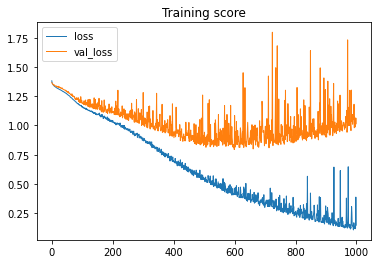

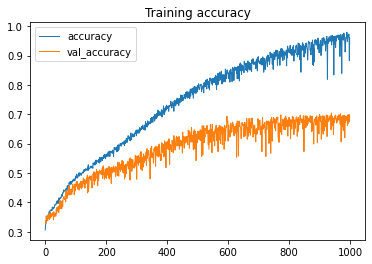

In [41]:
%%time
def train_model(X_train, y_train):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(p,)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(4, activation='linear'),
    ])

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    train_history = model.fit(
        X_train, 
        y_train,
        batch_size=128,
        epochs=1000, 
        validation_split=0.2, 
        verbose=0,
    )
    return model, train_history

def decide(arr):
    return np.argmax(arr, axis=1)


# On CPU+GPU (default)
model, train_history = train_model(X_train, y_train)
_ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
_ = pd.DataFrame(train_history.history)[['accuracy', 'val_accuracy']].plot(title='Training accuracy', lw=1)

model = tf.keras.models.Sequential([model, tf.keras.layers.Softmax()])
print(f'Train score {accuracy_score(y_train, decide(model.predict(X_train))):.3f}')
print(f'Test score  {accuracy_score(y_test, decide(model.predict(X_test))):.3f}')

Train score 0.911
Test score  0.673
CPU times: user 10min 11s, sys: 22.6 s, total: 10min 33s
Wall time: 1min 59s


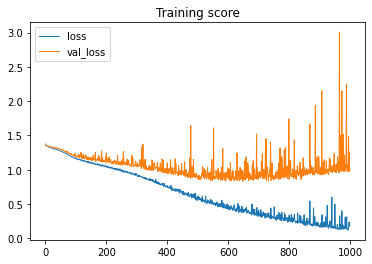

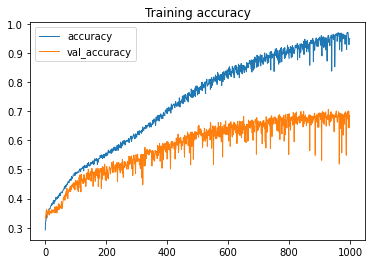

In [42]:
%%time
# on CPU
with tf.device('CPU:0'):
    model, train_history = train_model(X_train, y_train)
    _ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
    _ = pd.DataFrame(train_history.history)[['accuracy', 'val_accuracy']].plot(title='Training accuracy', lw=1)

    model = tf.keras.models.Sequential([model, tf.keras.layers.Softmax()])
    print(f'Train score {accuracy_score(y_train, decide(model.predict(X_train))):.3f}')
    print(f'Test score  {accuracy_score(y_test, decide(model.predict(X_test))):.3f}')

Train score 0.915
Test score  0.695
CPU times: user 1min 39s, sys: 9.6 s, total: 1min 49s
Wall time: 58.2 s


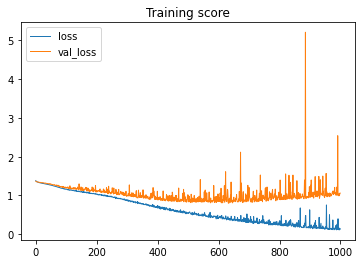

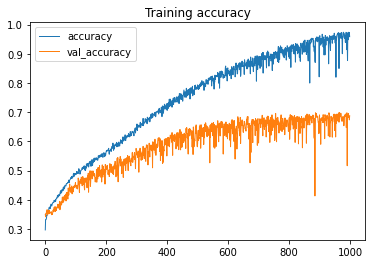

In [43]:
%%time
with tf.device('GPU:0'):
    model, train_history = train_model(X_train, y_train)
    _ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
    _ = pd.DataFrame(train_history.history)[['accuracy', 'val_accuracy']].plot(title='Training accuracy', lw=1)

    model = tf.keras.models.Sequential([model, tf.keras.layers.Softmax()])
    print(f'Train score {accuracy_score(y_train, decide(model.predict(X_train))):.3f}')
    print(f'Test score  {accuracy_score(y_test, decide(model.predict(X_test))):.3f}')

## PyTorch

In [44]:
torch.cuda.is_available()

True

In [45]:
class PrepareData(Dataset):
    def __init__(self, X, y, device_name=None):
        if not torch.is_tensor(X):
            X = torch.from_numpy(X).float()
        if not torch.is_tensor(y):
            y = torch.from_numpy(y[:]).long()
        self.X = X
        self.y = y
        if device_name is not None:
            device = torch.device(device_name)
            self.X = self.X.to(device)
            self.y = self.y.to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Train 0.923
Test  0.679
CPU times: user 28min 17s, sys: 0 ns, total: 28min 17s
Wall time: 2min 37s


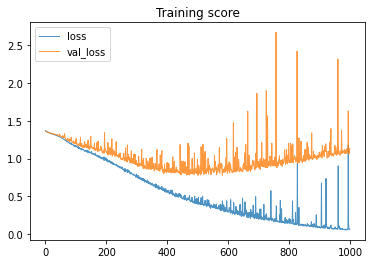

In [46]:
%%time
def train_model(X_train, y_train, device_name=None):
    model = torch.nn.Sequential(
        torch.nn.Linear(p, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, 4),
    )
    if device_name is not None:
        device = torch.device(device_name)
        model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_func = torch.nn.CrossEntropyLoss()

    X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, train_size=0.8)
    train_loader = DataLoader(PrepareData(X_train_1, y=y_train_1, device_name=device_name), batch_size=128, shuffle=True)
    val_loader = DataLoader(PrepareData(X_train_2, y=y_train_2, device_name=device_name), batch_size=128, shuffle=True)
    test_loader = DataLoader(PrepareData(X_test, y=y_test, device_name=device_name), batch_size=128, shuffle=True)
    train_history = defaultdict(list)
    
    for epoch in range(1000):
        loss_c = 0
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()
            y_train_batch_hat = model(X_train_batch)
            loss = loss_func(y_train_batch_hat, y_train_batch)
            loss.backward()
            optimizer.step()
            loss_c += loss.item()
        train_history['loss'].append(loss_c/len(train_loader))

        with torch.no_grad():
            val_loss_c = 0
            for X_val_batch, y_val_batch in val_loader:
                y_val_batch_hat = model(X_val_batch)
                val_loss = loss_func(y_val_batch_hat, y_val_batch)
                val_loss_c += val_loss.item()
            train_history['val_loss'].append(val_loss_c/len(val_loader))
    return model, train_history

def decide(arr):
    return np.argmax(arr, axis=1)

# on CPU (default)
model, train_history = train_model(X_train, y_train)
_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)
print(f'Train {accuracy_score(y_train, decide(model(torch.from_numpy(X_train).float()).detach().numpy())):.3f}')
print(f'Test  {accuracy_score(y_test, decide(model(torch.from_numpy(X_test).float()).detach().numpy())):.3f}')

Train 0.930
Test  0.692
CPU times: user 28min 16s, sys: 0 ns, total: 28min 16s
Wall time: 2min 36s


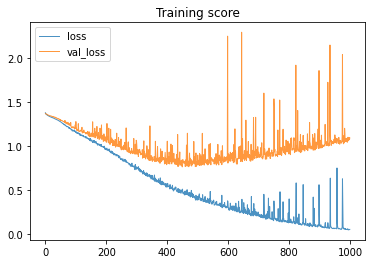

In [47]:
%%time
# on CPU
model, train_history = train_model(X_train, y_train, 'cpu')
_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)
print(f'Train {accuracy_score(y_train, decide(model(torch.from_numpy(X_train).float()).detach().numpy())):.3f}')
print(f'Test  {accuracy_score(y_test, decide(model(torch.from_numpy(X_test).float()).detach().numpy())):.3f}')

Train 0.927
Test  0.683
CPU times: user 1min 14s, sys: 0 ns, total: 1min 14s
Wall time: 1min 13s


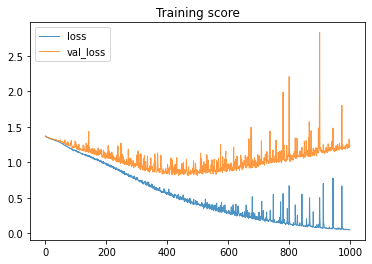

In [48]:
%%time
# on GPU
model, train_history = train_model(X_train, y_train, 'cuda:0')
_ = pd.DataFrame(train_history).plot(title='Training score', lw=1, alpha=0.8)
ds_train = PrepareData(X_train, y_train, 'cuda:0')
ds_test = PrepareData(X_test, y_test, 'cuda:0')
print(f'Train {accuracy_score(y_train, decide(model(ds_train.X).detach().cpu().numpy())):.3f}')
print(f'Test  {accuracy_score(y_test, decide(model(ds_test.X).detach().cpu().numpy())):.3f}')

# Feedforward 4.2: Complex Multiclass Classification
(Model Regularization)

- 3 hidden layers with ReLU activation
- Softmax output
- Cross-entropy
- SGD optimization
- Regularization: 
    - Parameter Norm Penalty
    - Parameter Norm Constraint 
    - Representation Norm Penalty
    - Early Stopping 
    - Parameter Noise
    - Droupout
    - Batch Normalization
- Minibatch (128 samples)

-------  ------  -------  -------  -------  -------  -------
 0.8195  0.5307   1.1800  -0.8969   2.0335  -4.3214   6.3589
-0.2979  1.5819  -0.3713   0.9535  -0.6564  -8.5789  -5.5887
-0.2369  2.2019   0.3770   0.8311   0.9335  -2.4884   9.8127
-------  ------  -------  -------  -------  -------  -------
-
2
3
2
-
Bayes score 0.881


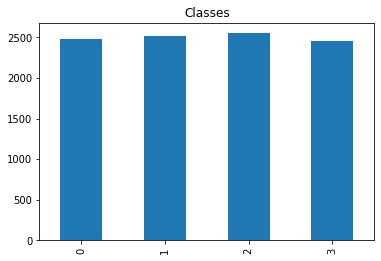

In [12]:
n = 10000
p = 7
train_rate = 0.7

def f1(X):
    h = (
        0.5 * X[:, 0] + 
        np.abs(X[:, 1]) - np.abs(X[:, 2]) +
        np.abs(X[:, 3]) * np.sign(X[:, -1]) + 
        0.5 * np.sum(X[:, :-3] * X[:, 1:-2], axis=1) + 
        2 * np.sin(X[:, -2]) * np.arctan(X[:, -1]) +
        np.prod(X[:, :4], axis=1) * np.exp(X[:, 3])
    )
    return h

def f2(h):
    return (h > -2).astype(int) + (h > 0).astype(int) + (h > 2).astype(int)

X = np.random.normal(0, (1., 1., 1., 1., 1., 5., 10.), size=(n, p))
y = f1(X) + np.random.normal(0, 0.4, size=n)
y = f2(y)
print(tabulate(X[-3:], floatfmt='.4f'))
print(tabulate(y[-3:, np.newaxis]))

n_train = int(n*train_rate)

X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

_ = pd.Series(y).value_counts(sort=False).plot(kind='bar', title='Classes')
print(f'Bayes score {accuracy_score(y, f2(f1(X))):.3f}')

## Baseline: Gradient Boosting

In [51]:
%%time

model = LGBMClassifier(
    n_estimators=1000, 
    min_data_in_leaf=10,
    learning_rate=0.01,
    objective='cross_entropy',
)

model.fit(X_train, y_train)
print(f'Train score {accuracy_score(y_train, model.predict(X_train)):.3f}')
print(f'Test score  {accuracy_score(y_test, model.predict(X_test)):.3f}')

Train score 0.927
Test score  0.679
CPU times: user 40.3 s, sys: 0 ns, total: 40.3 s
Wall time: 3.4 s


## TF2
(new design)

In [52]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train[:, np.newaxis]))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test[:, np.newaxis]))

In [53]:
def train_eval_model(model, optimizer, loss, train_ds, test_ds, callbacks=None, device_name=None, n_epoch=1000):
    with tf.device(device_name):
        k = int(len(train_ds)*0.8)
        train_ds_ = train_ds.take(k).batch(128)
        val_ds_ = train_ds.skip(k).batch(128)
        test_ds = test_ds.batch(128)
        
        model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

        train_history = model.fit(
            train_ds_,
            epochs=n_epoch, 
            validation_data=val_ds_,
            verbose=0,
            callbacks=callbacks,
        )

        _ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
        _ = pd.DataFrame(train_history.history)[['accuracy', 'val_accuracy']].plot(title='Training accuracy', lw=1)

#         model = tf.keras.models.Sequential([model, tf.keras.layers.Softmax()])
        train_loss, train_accuracy = model.evaluate(train_ds_)
        print(f'Train accuracy {train_accuracy:.3f}')
        test_loss, test_accuracy = model.evaluate(test_ds)
        print(f'Test accuracy  {test_accuracy:.3f}')

44/44 [==============================] - 0s 1ms/step - loss: 0.1145 - accuracy: 0.9729
Train accuracy 0.973
24/24 [==============================] - 0s 1000us/step - loss: 0.9530 - accuracy: 0.6917
Test accuracy  0.692
CPU times: user 2min 24s, sys: 3.64 s, total: 2min 27s
Wall time: 1min 26s


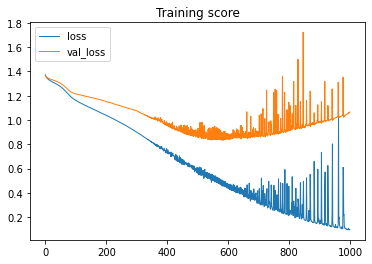

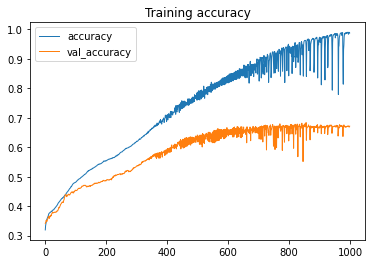

In [54]:
%%time
# No reglarization
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(p,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='linear'),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.01)

train_eval_model(model, optimizer, loss, train_ds, test_ds)

44/44 [==============================] - 0s 1ms/step - loss: 0.7490 - accuracy: 0.8820
Train accuracy 0.882
24/24 [==============================] - 0s 936us/step - loss: 1.0828 - accuracy: 0.7153
Test accuracy  0.715
CPU times: user 2min 9s, sys: 9.57 s, total: 2min 18s
Wall time: 1min 18s


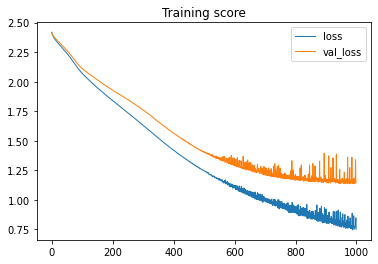

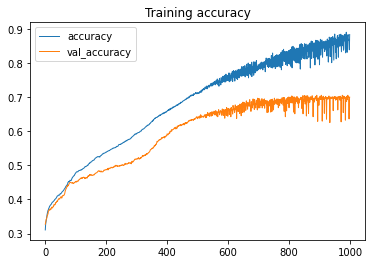

In [55]:
%%time
# L2 Norm Parameter Penalty
kernel_regularizer=tf.keras.regularizers.l2(0.001)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=kernel_regularizer, input_shape=(p,)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=kernel_regularizer),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=kernel_regularizer),
    tf.keras.layers.Dense(4, activation='linear', kernel_regularizer=kernel_regularizer),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.01)

train_eval_model(model, optimizer, loss, train_ds, test_ds)

44/44 [==============================] - 0s 963us/step - loss: 0.9272 - accuracy: 0.8954
Train accuracy 0.895
24/24 [==============================] - 0s 1ms/step - loss: 1.2952 - accuracy: 0.7273
Test accuracy  0.727
CPU times: user 2min 14s, sys: 9.53 s, total: 2min 23s
Wall time: 1min 20s


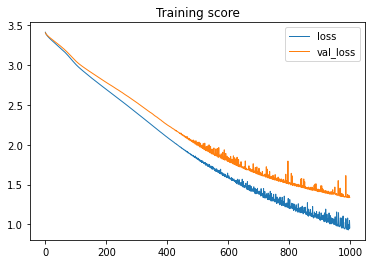

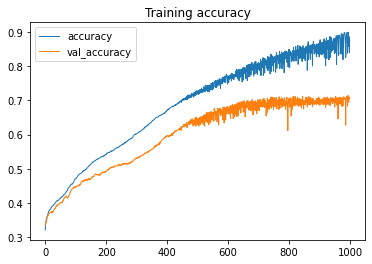

In [56]:
%%time
# L1 Norm Parameter Penalty
kernel_regularizer=tf.keras.regularizers.l1(0.0001)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=kernel_regularizer, input_shape=(p,)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=kernel_regularizer),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=kernel_regularizer),
    tf.keras.layers.Dense(4, activation='linear', kernel_regularizer=kernel_regularizer),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.01)

train_eval_model(model, optimizer, loss, train_ds, test_ds)

44/44 [==============================] - 0s 1ms/step - loss: 1.1054 - accuracy: 0.5143
Train accuracy 0.514
24/24 [==============================] - 0s 881us/step - loss: 1.1542 - accuracy: 0.4807
Test accuracy  0.481
CPU times: user 2min 50s, sys: 13.5 s, total: 3min 4s
Wall time: 1min 53s


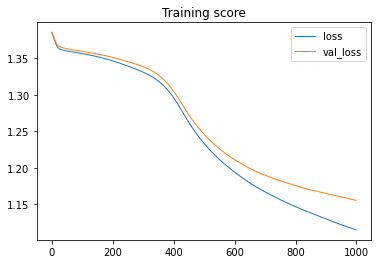

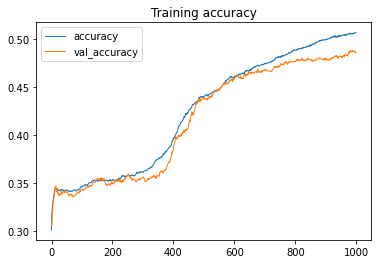

In [57]:
%%time
# L2 Norm Parameter Max Constraint
kernel_constraint=tf.keras.constraints.MaxNorm(0.3)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', kernel_constraint=kernel_constraint, input_shape=(p,)),
    tf.keras.layers.Dense(512, activation='relu', kernel_constraint=kernel_constraint),
    tf.keras.layers.Dense(512, activation='relu', kernel_constraint=kernel_constraint),
    tf.keras.layers.Dense(4, activation='linear', kernel_constraint=kernel_constraint),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.01)

train_eval_model(model, optimizer, loss, train_ds, test_ds)

44/44 [==============================] - 0s 913us/step - loss: 0.5342 - accuracy: 0.7970
Train accuracy 0.797
24/24 [==============================] - 0s 1ms/step - loss: 0.7886 - accuracy: 0.6627
Test accuracy  0.663
CPU times: user 2min 55s, sys: 13.7 s, total: 3min 9s
Wall time: 1min 56s


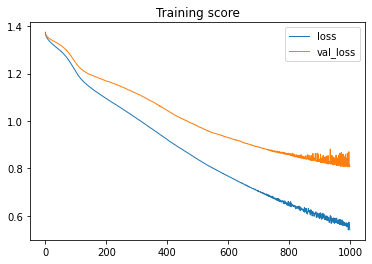

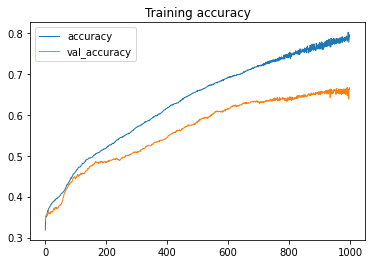

In [58]:
%%time
# L2 Norm Parameter Min-Max Constraint
kernel_constraint=tf.keras.constraints.MinMaxNorm(0.1)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', kernel_constraint=kernel_constraint, input_shape=(p,)),
    tf.keras.layers.Dense(512, activation='relu', kernel_constraint=kernel_constraint),
    tf.keras.layers.Dense(512, activation='relu', kernel_constraint=kernel_constraint),
    tf.keras.layers.Dense(4, activation='linear', kernel_constraint=kernel_constraint),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.01)

train_eval_model(model, optimizer, loss, train_ds, test_ds)

44/44 [==============================] - 0s 1ms/step - loss: 0.6700 - accuracy: 0.8141
Train accuracy 0.814
24/24 [==============================] - 0s 1ms/step - loss: 1.2582 - accuracy: 0.5273
Test accuracy  0.527


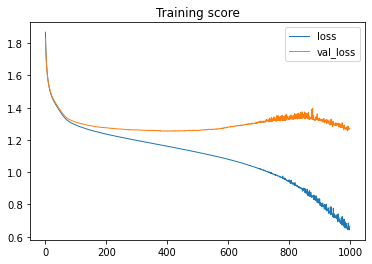

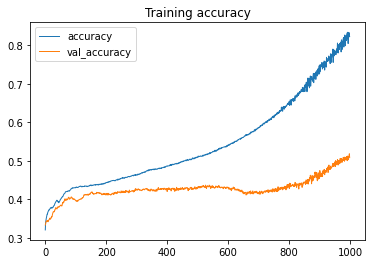

In [59]:
# %%time
# L1 Norm Representation Penalty
activity_regularizer=tf.keras.regularizers.l1(0.002)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', activity_regularizer=activity_regularizer, input_shape=(p,)),
    tf.keras.layers.Dense(512, activation='relu', activity_regularizer=activity_regularizer),
    tf.keras.layers.Dense(512, activation='relu', activity_regularizer=activity_regularizer),
    tf.keras.layers.Dense(4, activation='linear', activity_regularizer=activity_regularizer),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.01)

train_eval_model(model, optimizer, loss, train_ds, test_ds)

44/44 [==============================] - 0s 1ms/step - loss: 0.4138 - accuracy: 0.8418
Train accuracy 0.842
24/24 [==============================] - 0s 1ms/step - loss: 0.8443 - accuracy: 0.6553
Test accuracy  0.655
CPU times: user 1min 30s, sys: 7.43 s, total: 1min 38s
Wall time: 57.4 s


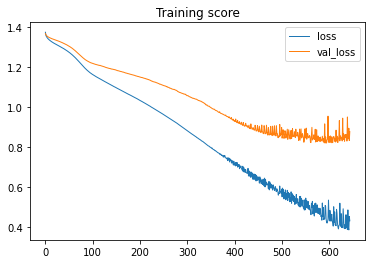

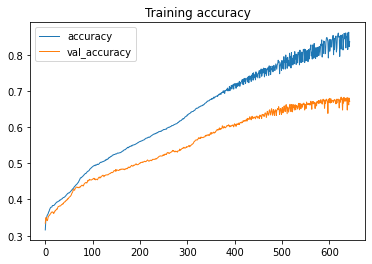

In [60]:
%%time
# Early Stopping
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(p,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='linear'),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.01)

train_eval_model(model, optimizer, loss, train_ds, test_ds, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)])

44/44 [==============================] - 0s 1ms/step - loss: 0.1182 - accuracy: 0.9693
Train accuracy 0.969
24/24 [==============================] - 0s 957us/step - loss: 1.0499 - accuracy: 0.6793
Test accuracy  0.679
CPU times: user 2min 32s, sys: 12.3 s, total: 2min 45s
Wall time: 1min 38s


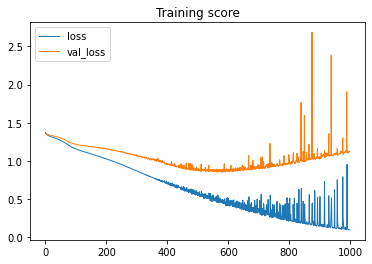

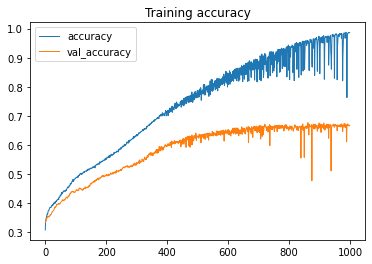

In [61]:
%%time
# Add Gaussian Noise to Parameters
noise_stddev=0.01
model = tf.keras.models.Sequential([
    tf.keras.layers.GaussianNoise(noise_stddev, input_shape=(p,)),
    tf.keras.layers.Dense(512, activation='relu', input_shape=(p,)),
    tf.keras.layers.GaussianNoise(noise_stddev),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.GaussianNoise(noise_stddev),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.GaussianNoise(noise_stddev),
    tf.keras.layers.Dense(4, activation='linear'),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.01)

train_eval_model(model, optimizer, loss, train_ds, test_ds)

44/44 [==============================] - 0s 1ms/step - loss: 1.2315 - accuracy: 0.4227
Train accuracy 0.423
24/24 [==============================] - 0s 889us/step - loss: 1.2529 - accuracy: 0.3723
Test accuracy  0.372
CPU times: user 2min 38s, sys: 12.6 s, total: 2min 50s
Wall time: 1min 43s


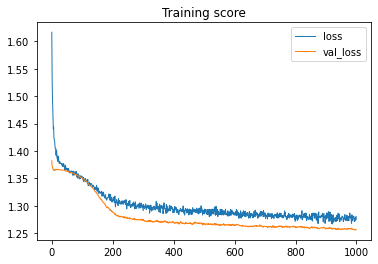

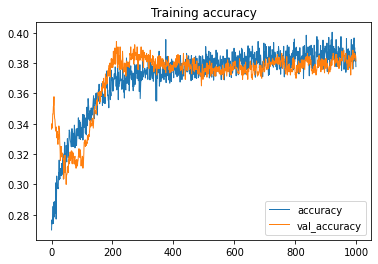

In [62]:
%%time
# Dropout
dropout_rate_input = 0.2
dropout_rate = 0.5
model = tf.keras.models.Sequential([
    tf.keras.layers.Dropout(dropout_rate_input, input_shape=(p,)),
    tf.keras.layers.Dense(512, activation='relu', input_shape=(p,)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(4, activation='linear'),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.01)

train_eval_model(model, optimizer, loss, train_ds, test_ds)

44/44 [==============================] - 0s 1ms/step - loss: 0.2080 - accuracy: 0.9246
Train accuracy 0.925
24/24 [==============================] - 0s 1ms/step - loss: 3.5523 - accuracy: 0.3987
Test accuracy  0.399
CPU times: user 3min 33s, sys: 15.8 s, total: 3min 49s
Wall time: 2min 13s


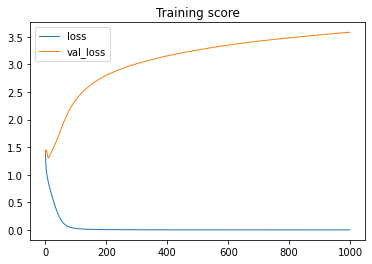

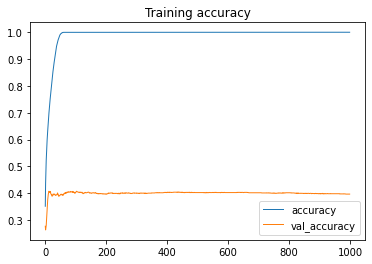

In [63]:
%%time
# Batch Normalization
# https://www.machinecurve.com/index.php/2020/01/15/how-to-use-batch-normalization-with-keras/
# TODO: fix performance drop (?)
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(p,)),
    tf.keras.layers.Dense(512, activation='relu', input_shape=(p,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation='linear'),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.01)

train_eval_model(model, optimizer, loss, train_ds, test_ds)

## PyTorch
(new design)

In [64]:
class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            X = torch.from_numpy(X).float()
        if not torch.is_tensor(y):
            y = torch.from_numpy(y[:]).long()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)
    

ds_train = PrepareData(X_train, y_train)
ds_test = PrepareData(X_test, y_test)

In [74]:
def eval_loss_nograd(model, loss_func, loader):
    with torch.no_grad():
        loss_c = 0
        for X_batch, y_batch in loader:
            loss = loss_func(model(X_batch), y_batch)
            loss_c += loss.item()
        return loss_c / len(loader) 
    
def torch_accuracy_score(predicted, labels):
    predicted = torch.argmax(predicted.data, 1)
    n_correct = (predicted == labels).sum() / float(len(predicted))
    return n_correct

def train_eval_model(model, optimizer, loss_func, train_ds, test_ds, device_name=None, n_epoch=1000):
    if device_name is not None:
        if device_name == 'auto':
            device_name = 'cuda' if torch.cuda.is_available() else 'gpu'
        device = torch.device(device_name)
        model.to(device)
        train_ds.to(device)
        test_ds.to(device)
        print(f'Running on {device_name}...')

    train_size = int(len(train_ds)*0.8)
    train_ds, val_ds = torch.utils.data.random_split(train_ds, [train_size, len(train_ds)-train_size])
    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)
 
    train_history = defaultdict(list)
    for epoch in range(n_epoch):
        loss_c = 0
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_func(model(X_train_batch), y_train_batch)
            loss.backward()
            optimizer.step()
            loss_c += loss.item()
        train_history['loss'].append(loss_c/len(train_loader))

        train_history['val_loss'].append(eval_loss_nograd(model, loss_func, val_loader))
        train_history['accuracy'].append(eval_loss_nograd(model, torch_accuracy_score, train_loader))
        train_history['val_accuracy'].append(eval_loss_nograd(model, torch_accuracy_score, val_loader))
    
    train_accuracy = eval_loss_nograd(model, torch_accuracy_score, train_loader)
    test_accuracy = eval_loss_nograd(model, torch_accuracy_score, test_loader)
    
    _ = pd.DataFrame(train_history)[['loss', 'val_loss']].plot(title='Training loss', lw=1, alpha=0.8)
    _ = pd.DataFrame(train_history)[['accuracy', 'val_accuracy']].plot(title='Training accuracy', lw=1, alpha=0.8)
    print(f'Train accuracy {train_accuracy:.3f}')
    print(f'Test accuracy  {test_accuracy:.3f}')

Running on cuda...
Train accuracy 0.997
Test accuracy  0.695
CPU times: user 2min 2s, sys: 458 ms, total: 2min 2s
Wall time: 2min 2s


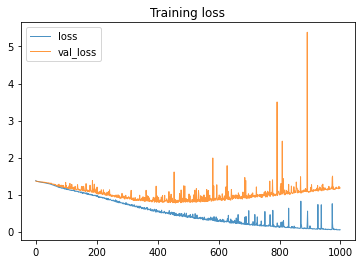

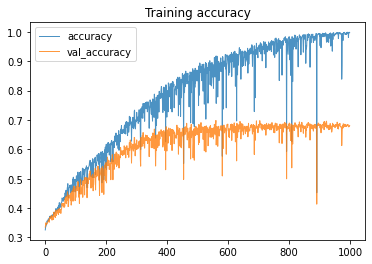

In [66]:
%%time
# No regularization
model = torch.nn.Sequential(
    torch.nn.Linear(p, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 4),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()
train_eval_model(model, optimizer, loss_func, ds_train, ds_test, 'auto')

Running on cuda...
Train accuracy 0.959
Test accuracy  0.709
CPU times: user 2min 5s, sys: 382 ms, total: 2min 5s
Wall time: 2min 5s


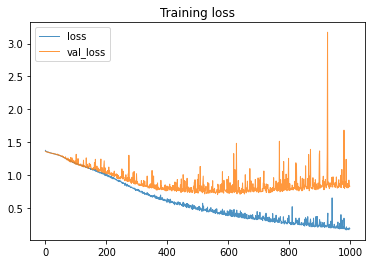

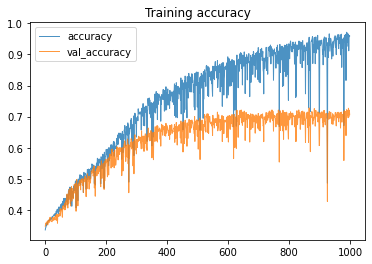

In [67]:
%%time
# L2 Norm Parameter Penalty
model = torch.nn.Sequential(
    torch.nn.Linear(p, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 4),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
loss_func = torch.nn.CrossEntropyLoss()
train_eval_model(model, optimizer, loss_func, ds_train, ds_test, 'auto')

Running on cuda...
Train accuracy 0.423
Test accuracy  0.406
CPU times: user 4min 26s, sys: 985 ms, total: 4min 27s
Wall time: 4min 26s


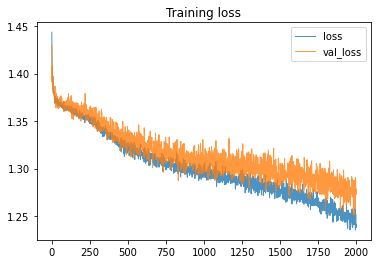

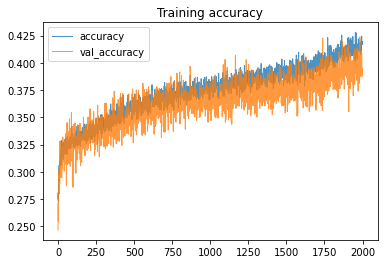

In [68]:
%%time
# Dropout
dropout_rate_input = 0.2
dropout_rate = 0.5
model = torch.nn.Sequential(
    torch.nn.Dropout(dropout_rate_input),
    torch.nn.Linear(p, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(dropout_rate),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(dropout_rate),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(dropout_rate),
    torch.nn.Linear(512, 4),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()
train_eval_model(model, optimizer, loss_func, ds_train, ds_test, 'auto', n_epoch=2000)

Running on cuda...
Train accuracy 0.982
Test accuracy  0.413
CPU times: user 2min 46s, sys: 468 ms, total: 2min 47s
Wall time: 2min 46s


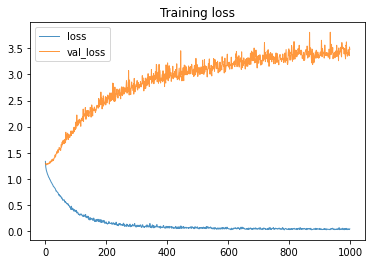

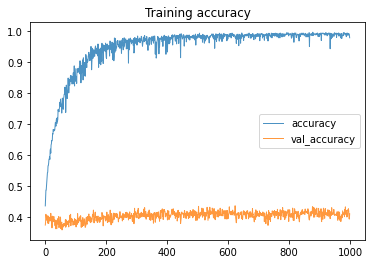

In [69]:
%%time
# Batch Normalization
# https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d
# TODO: fix performance drop (?)
model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(p),
    torch.nn.Linear(p, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(512),
    torch.nn.Linear(512, 4),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()
train_eval_model(model, optimizer, loss_func, ds_train, ds_test, 'auto')

# Feedforward 4.3: Complex Multiclass Classification
(Pre-training and Multitask Learning)

- 3 hidden layers with ReLU activation
- Softmax output
- Cross-entropy
- SGD optimization
- Minibatch (128 samples)

-------  ------  -------  -------  -------  -------  --------
 0.7814  0.0878  -2.3960  -1.0338  -0.9941   3.0926   18.7487
-0.8789  1.9645   0.7893   1.3566   0.5572   3.6197   15.4971
-0.5643  1.9063  -0.4878   1.6145  -1.1771  -4.7665  -12.3497
-------  ------  -------  -------  -------  -------  --------
-
2
0
1
-
Bayes accuracy 0.883


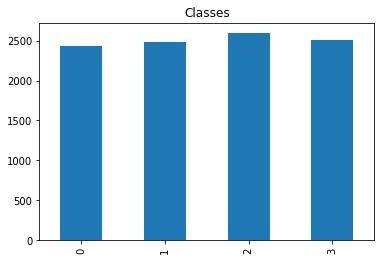

In [3]:
n = 10000
p = 7
train_rate = 0.7

def f1(X):
    h = (
        0.5 * X[:, 0] + 
        np.abs(X[:, 1]) - np.abs(X[:, 2]) +
        np.abs(X[:, 3]) * np.sign(X[:, -1]) + 
        0.5 * np.sum(X[:, :-3] * X[:, 1:-2], axis=1) + 
        2 * np.sin(X[:, -2]) * np.arctan(X[:, -1]) +
        np.prod(X[:, :4], axis=1) * np.exp(X[:, 3])
    )
    return h

def f2(h):
    return (h > -2).astype(int) + (h > 0).astype(int) + (h > 2).astype(int)

X = np.random.normal(0, (1., 1., 1., 1., 1., 5., 10.), size=(n, p))
y = f1(X) + np.random.normal(0, 0.4, size=n)
y = f2(y)
print(tabulate(X[-3:], floatfmt='.4f'))
print(tabulate(y[-3:, np.newaxis]))

n_train = int(n*train_rate)

X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

_ = pd.Series(y).value_counts(sort=False).plot(kind='bar', title='Classes')
print(f'Bayes accuracy {accuracy_score(y, f2(f1(X))):.3f}')

-------  -------  -------  ------  ------  -------  -------
 1.1304  -0.7462  -0.4738  0.3440  1.3538  -0.9113   1.7907
-0.4533  -0.9503   0.8808  2.0234  2.7709  -1.3085  -0.7950
 1.3597  -0.3734   0.8573  0.6485  0.7611  -0.9633  -2.0302
-------  -------  -------  ------  ------  -------  -------
---------
-0.895085
 6.25499
 1.6034
---------
Bayes MAE 0.240


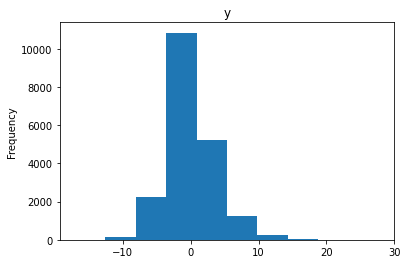

In [4]:
# A related dataset
n_1 = 20000
p_1 = 7
train_rate_1 = 0.7

def f1(X):
    h = (
        np.sum(X, axis=1) + 
        np.sum(X[:, :-1] * X[:, 1:], axis=1)
    )
    return h

X_1 = np.random.normal(0, 1, size=(n_1, p_1))
y_1 = f1(X_1) + np.random.normal(0, 0.3, size=n_1)
print(tabulate(X_1[-3:], floatfmt='.4f'))
print(tabulate(y_1[-3:, np.newaxis]))

n_train_1 = int(n_1*train_rate_1)

X_train_1 = X_1[:n_train_1]
y_train_1 = y_1[:n_train_1]
X_test_1 = X_1[n_train_1:]
y_test_1 = y_1[n_train_1:]

_ = pd.Series(y_1).plot(kind='hist', title='y')
print(f'Bayes MAE {mean_absolute_error(y_1, f1(X_1)):.3f}')

------  -------  -------  -------  -------  -------  -------
0.1464  -0.6494   0.7584  -0.5039  -0.6895   0.2664  -0.8761
0.2919  -0.6165  -0.1866  -0.3088  -1.8790  -1.2341   0.8480
1.4544  -0.5358   2.5658   0.1065   0.7685   0.2975  -0.6896
------  -------  -------  -------  -------  -------  -------
--------
0.528592
5.00608
7.55906
--------
Bayes MAE 0.241


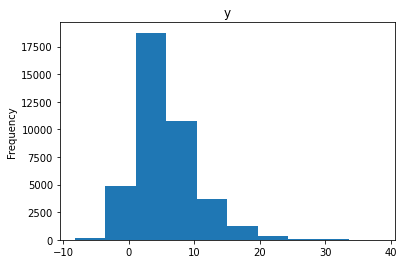

In [5]:
# A related dataset
n_2 = 40000
p_2 = 7
train_rate_2 = 0.7

def f1(X):
    h = (
        np.sum(X, axis=1) + 
        np.sum(np.abs(X), axis=1) + 
        np.sum(X[:, :-1] * X[:, 1:], axis=1) +
        np.sum(np.sin(X[:, :-1]) * np.arctan(X[:, 1:]), axis=1)
    )
    return h

X_2 = np.random.normal(0, 1, size=(n_2, p_2))
y_2 = f1(X_2) + np.random.normal(0, 0.3, size=n_2)
print(tabulate(X_2[-3:], floatfmt='.4f'))
print(tabulate(y_2[-3:, np.newaxis]))

n_train_2 = int(n_2*train_rate_2)

X_train_2 = X_2[:n_train_2]
y_train_2 = y_2[:n_train_2]
X_test_2 = X_2[n_train_2:]
y_test_2 = y_2[n_train_2:]

_ = pd.Series(y_2).plot(kind='hist', title='y')
print(f'Bayes MAE {mean_absolute_error(y_2, f1(X_2)):.3f}')

## Baseline: Gradient Boosting

In [6]:
%%time
# main dataset
model = LGBMClassifier(
    n_estimators=1000, 
    min_data_in_leaf=10,
    learning_rate=0.01,
    objective='cross_entropy',
)

model.fit(X_train, y_train)
print(f'Train score {accuracy_score(y_train, model.predict(X_train)):.3f}')
print(f'Test score  {accuracy_score(y_test, model.predict(X_test)):.3f}')

Train score 0.924
Test score  0.657
CPU times: user 48.9 s, sys: 435 ms, total: 49.4 s
Wall time: 4.25 s


In [7]:
%%time
# aux dataset 1
model = LGBMRegressor(
    n_estimators=1000, 
    min_data_in_leaf=10,
    learning_rate=0.01,
    objective='regression',
)

model.fit(X_train_1, y_train_1)
print(f'Train loss {mean_absolute_error(y_train_1, model.predict(X_train_1)):.3f}')
print(f'Test loss  {mean_absolute_error(y_test_1, model.predict(X_test_1)):.3f}')

Train loss 0.394
Test loss  0.517
CPU times: user 13.9 s, sys: 77 ms, total: 14 s
Wall time: 1.18 s


In [8]:
%%time
# aux dataset 2
model = LGBMRegressor(
    n_estimators=1000, 
    min_data_in_leaf=10,
    learning_rate=0.01,
    objective='regression',
)

model.fit(X_train_2, y_train_2)
print(f'Train loss {mean_absolute_error(y_train_2, model.predict(X_train_2)):.3f}')
print(f'Test loss  {mean_absolute_error(y_test_2, model.predict(X_test_2)):.3f}')

Train loss 0.564
Test loss  0.667
CPU times: user 16.4 s, sys: 101 ms, total: 16.5 s
Wall time: 1.39 s


## TF2

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train[:, np.newaxis]))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test[:, np.newaxis]))

train_ds_1 = tf.data.Dataset.from_tensor_slices((X_train_1, y_train_1[:, np.newaxis]))
test_ds_1 = tf.data.Dataset.from_tensor_slices((X_test_1, y_test_1[:, np.newaxis]))

train_ds_2 = tf.data.Dataset.from_tensor_slices((X_train_2, y_train_2[:, np.newaxis]))
test_ds_2 = tf.data.Dataset.from_tensor_slices((X_test_2, y_test_2[:, np.newaxis]))

In [10]:
def train_eval_model(model, optimizer, loss, train_ds, test_ds, metrics=tuple(), callbacks=None, device_name=None, 
                     n_epoch=1000, n_batch=128):
    with tf.device(device_name):
        k = int(len(train_ds)*0.8)
        train_ds_ = train_ds.take(k).batch(n_batch)
        val_ds_ = train_ds.skip(k).batch(n_batch)
        test_ds = test_ds.batch(n_batch)
        
        model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

        train_history = model.fit(
            train_ds_,
            epochs=n_epoch, 
            validation_data=val_ds_,
            verbose=0,
            callbacks=callbacks,
        )

        _ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training score', lw=1)
        for metric in metrics:
            _ = pd.DataFrame(train_history.history)[[metric, f'val_{metric}']].plot(title=f'Training metric', lw=1)

        train_results = model.evaluate(train_ds_)
        test_results = model.evaluate(test_ds)
        for i, metric in enumerate(metrics):
            print(f'Train {metric} {train_results[i+1]:.3f}')
            print(f'Test {metric} {test_results[i+1]:.3f}')

47/47 [==============================] - 0s 857us/step - loss: 0.1173 - mae: 0.2670
Train mae 0.219
Test mae 0.267
CPU times: user 2min 46s, sys: 15.4 s, total: 3min 2s
Wall time: 1min 33s


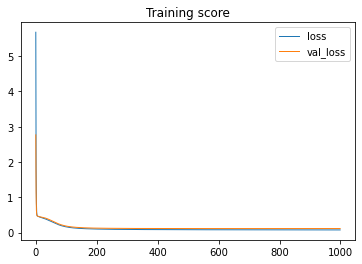

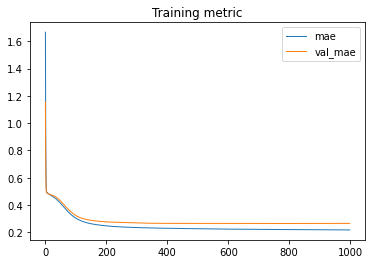

In [11]:
%%time
# Training on auxiliary dataset 1
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(p_1,)),
    tf.keras.layers.Dense(1, activation='linear'),
])
loss_1=tf.keras.losses.MeanSquaredError()
optimizer_1=tf.keras.optimizers.SGD(0.01)

train_eval_model(model_1, optimizer_1, loss_1, train_ds_1, test_ds_1, metrics=['mae'])

94/94 [==============================] - 0s 778us/step - loss: 0.1107 - mae: 0.2641
Train mae 0.229
Test mae 0.264
CPU times: user 5min 26s, sys: 31.8 s, total: 5min 58s
Wall time: 2min 58s


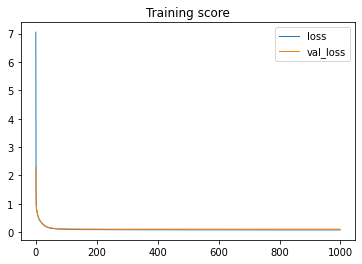

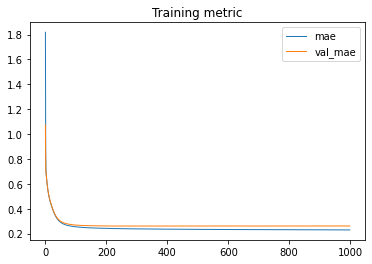

In [12]:
%%time
# Training on auxiliary dataset 2
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(p_2,)),
    tf.keras.layers.Dense(1, activation='linear'),
])
loss_2=tf.keras.losses.MeanSquaredError()
optimizer_2=tf.keras.optimizers.SGD(0.01)

train_eval_model(model_2, optimizer_2, loss_2, train_ds_2, test_ds_2, metrics=['mae'])

### No pre-training

24/24 [==============================] - 0s 937us/step - loss: 1.1294 - accuracy: 0.6790
Train accuracy 0.958
Test accuracy 0.679
CPU times: user 2min 8s, sys: 10.8 s, total: 2min 19s
Wall time: 1min 23s


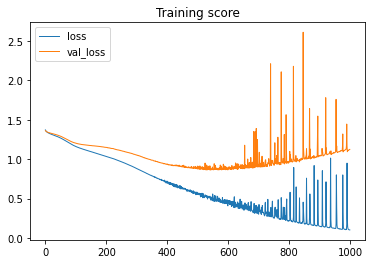

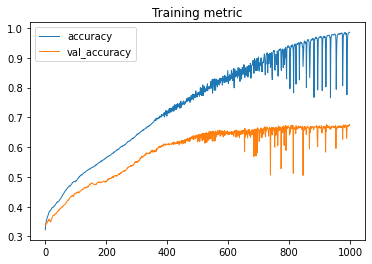

In [16]:
%%time
# No pre-training
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(p,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='linear'),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.01)

train_eval_model(model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'])

### Pre-training with aux dataset 1

24/24 [==============================] - 0s 979us/step - loss: 0.8821 - accuracy: 0.6530
Train accuracy 0.869
Test accuracy 0.653
CPU times: user 2min 35s, sys: 14.3 s, total: 2min 49s
Wall time: 1min 40s


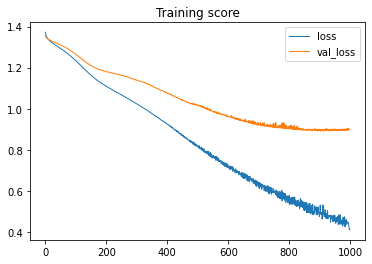

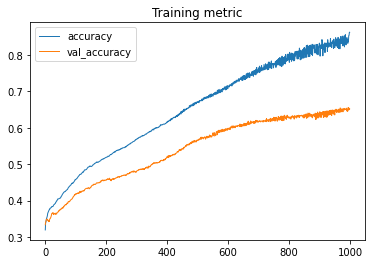

In [19]:
%%time
# Training with a pre-trained model 1 (frozen)
base_model = tf.keras.models.clone_model(tf.keras.models.Sequential(
    model_1.layers[0],
))
base_model.trainable = False
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='linear'),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.01)

train_eval_model(model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'])

24/24 [==============================] - 0s 997us/step - loss: 0.9374 - accuracy: 0.6523
Train accuracy 0.892
Test accuracy 0.652
CPU times: user 18.5 s, sys: 1.61 s, total: 20.1 s
Wall time: 12 s


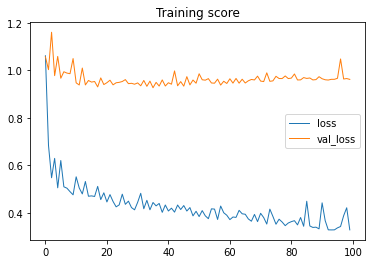

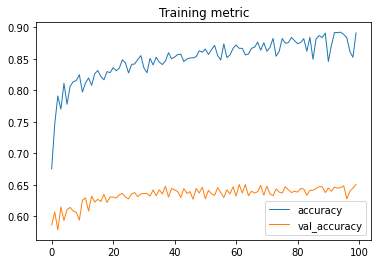

In [20]:
%%time
# Fine-tuning with a pre-trained model 1
base_model.trainable = True
train_eval_model(model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'], n_epoch=100)

24/24 [==============================] - 0s 998us/step - loss: 1.1169 - accuracy: 0.6797
Train accuracy 0.959
Test accuracy 0.680
CPU times: user 3min 3s, sys: 16.5 s, total: 3min 19s
Wall time: 1min 57s


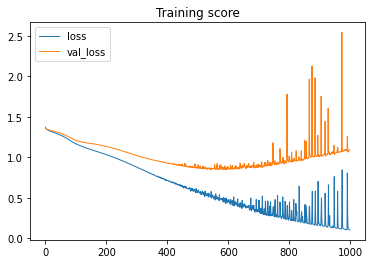

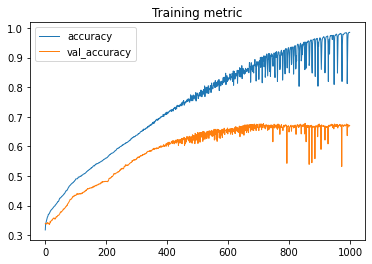

In [21]:
%%time
# Training with a pre-trained base model (1, trainable)
base_model = tf.keras.models.clone_model(tf.keras.models.Sequential(
    model_1.layers[0],
))
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='linear'),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.01)

train_eval_model(model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'])

In [32]:
%%time
# Shared parameters with aux model 1
# TODO: finish
# https://stackoverflow.com/questions/56889038/tensorflow-2-0-how-make-share-parameters-among-convolutional-layers
# https://www.pyimagesearch.com/2020/03/23/using-tensorflow-and-gradienttape-to-train-a-keras-model/

shared_input_layer = tf.keras.layers.Dense(512, activation='relu', input_shape=(p,))

model = tf.keras.models.Sequential([
    shared_input_layer,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='linear'),
])

aux_model = tf.keras.models.Sequential([
    shared_input_layer,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
])

loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_aux=tf.keras.losses.MeanSquaredError()
optimizer=tf.keras.optimizers.SGD(0.01)

# train_eval_model(model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'])
# train_eval_model(model_1, optimizer_1, loss_1, train_ds_1, test_ds_1, metrics=['mae'])

CPU times: user 37.7 ms, sys: 18.4 ms, total: 56.1 ms
Wall time: 52 ms


### Pre-training with aux dataset 2

24/24 [==============================] - 0s 995us/step - loss: 0.8823 - accuracy: 0.6623
Train accuracy 0.862
Test accuracy 0.662
CPU times: user 1min 58s, sys: 10.4 s, total: 2min 8s
Wall time: 1min 16s


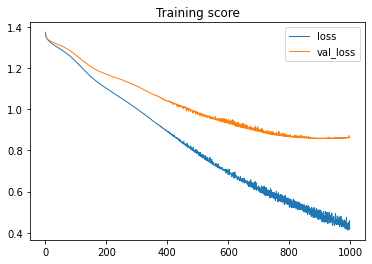

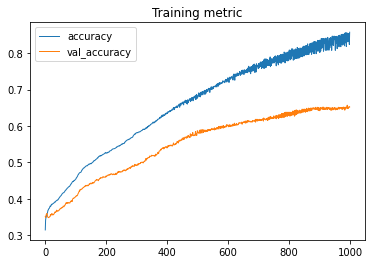

In [24]:
%%time
# Training with a pre-trained model 2 (frozen)
base_model = tf.keras.models.clone_model(tf.keras.models.Sequential(
    model_2.layers[0],
))
base_model.trainable = False
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='linear'),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.01)

train_eval_model(model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'])

24/24 [==============================] - 0s 905us/step - loss: 0.9435 - accuracy: 0.6580
Train accuracy 0.881
Test accuracy 0.658
CPU times: user 10.3 s, sys: 792 ms, total: 11.1 s
Wall time: 6.69 s


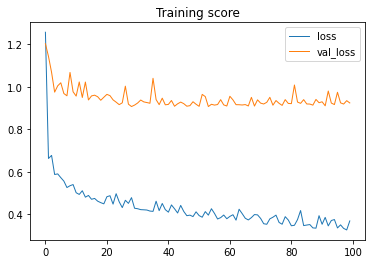

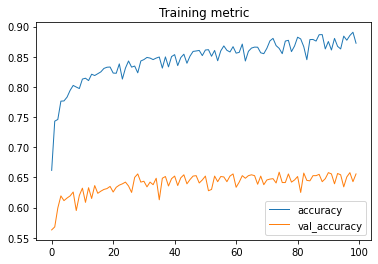

In [25]:
%%time
# Fine-tuning with a pre-trained model 2
base_model.trainable = True
train_eval_model(model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'], n_epoch=100)

24/24 [==============================] - 0s 981us/step - loss: 1.2484 - accuracy: 0.6553
Train accuracy 0.890
Test accuracy 0.655
CPU times: user 2min 12s, sys: 11.7 s, total: 2min 24s
Wall time: 1min 25s


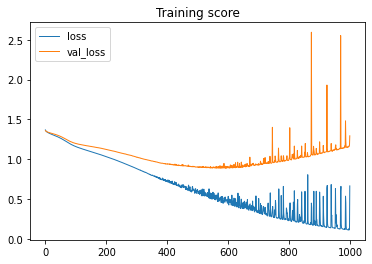

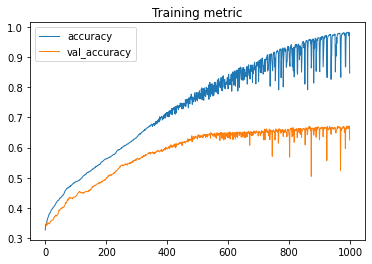

In [26]:
%%time
# Training with a pre-trained model 2 (trainable)
base_model = tf.keras.models.clone_model(tf.keras.models.Sequential(
    model_2.layers[0],
))
model = tf.keras.models.Sequential([
    base_model.layers[0],
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='linear'),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.01)

train_eval_model(model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'])

## PyTorch

- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648/13

In [48]:
class PrepareData(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            X = torch.from_numpy(X).float()
        if not torch.is_tensor(y):
            if y.dtype == 'int64':
                y = torch.from_numpy(y[:]).long()
            else:
                y = torch.from_numpy(y[:, np.newaxis]).float()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def to(self, device):
        self.X = self.X.to(device)
        self.y = self.y.to(device)
    

ds_train = PrepareData(X_train, y_train)
ds_test = PrepareData(X_test, y_test)

ds_train_1 = PrepareData(X_train_1, y_train_1)
ds_test_1 = PrepareData(X_test_1, y_test_1)

In [51]:
def eval_loss_nograd(model, loss_func, loader):
    with torch.no_grad():
        loss_c = 0
        for X_batch, y_batch in loader:
            loss = loss_func(model(X_batch), y_batch)
            loss_c += loss.item()
        return loss_c / len(loader) 
    
def torch_accuracy_score(predicted, labels):
    predicted = torch.argmax(predicted.data, 1)
    n_correct = (predicted == labels).sum() / float(len(predicted))
    return n_correct

def torch_mae(predicted, labels):
    return (predicted - labels).abs().sum() / float(len(predicted))

torch_metrics = {
    'accuracy': torch_accuracy_score,
    'mae': torch_mae,
}

def train_eval_model(model, optimizer, loss_func, train_ds, test_ds, device_name=None, metrics=tuple(),
                     n_epoch=1000, n_batch=128):
    if device_name is not None:
        if device_name == 'auto':
            device_name = 'cuda' if torch.cuda.is_available() else 'gpu'
        device = torch.device(device_name)
        model.to(device)
        train_ds.to(device)
        test_ds.to(device)
        print(f'Running on {device_name}...')

    train_size = int(len(train_ds)*0.8)
    train_ds, val_ds = torch.utils.data.random_split(train_ds, [train_size, len(train_ds)-train_size])
    train_loader = DataLoader(train_ds, batch_size=n_batch, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=n_batch, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=n_batch, shuffle=True)
 
    train_history = defaultdict(list)
    for epoch in range(n_epoch):
        loss_c = 0
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_func(model(X_train_batch), y_train_batch)
            loss.backward()
            optimizer.step()
            loss_c += loss.item()
        train_history['loss'].append(loss_c/len(train_loader))

        train_history['val_loss'].append(eval_loss_nograd(model, loss_func, val_loader))
        for metric in metrics:
            train_history[metric].append(eval_loss_nograd(model, torch_metrics[metric], train_loader))
            train_history[f'val_{metric}'].append(eval_loss_nograd(model, torch_metrics[metric], val_loader))

    _ = pd.DataFrame(train_history)[['loss', 'val_loss']].plot(title='Training loss', lw=1, alpha=0.8)

    for metric in metrics:
        _ = pd.DataFrame(train_history)[[metric, f'val_{metric}']].plot(title='Training {metric}', lw=1, alpha=0.8)
        train_metric = eval_loss_nograd(model, torch_metrics[metric], train_loader)
        test_metric = eval_loss_nograd(model, torch_metrics[metric], test_loader)
        print(f'Train {metric} {train_metric:.3f}')
        print(f'Test {metric}  {test_metric:.3f}')

Running on cuda...
Train mae 0.213
Test mae  0.274


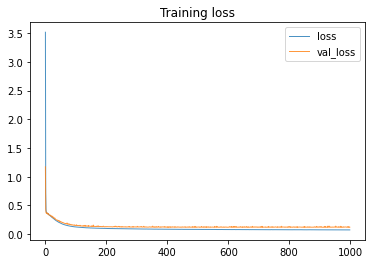

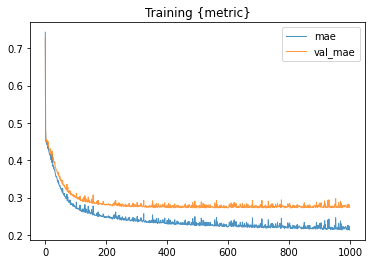

In [52]:
%%time
# Training on auxiliary dataset 1
model_1 = torch.nn.Sequential(
    torch.nn.Linear(p_1, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 1),
)
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=0.01)
loss_func_1 = torch.nn.MSELoss()
train_eval_model(model_1, optimizer_1, loss_func_1, ds_train_1, ds_test_1, metrics=['mae'], device_name='auto')

### No pre-training

Running on cuda...
Train accuracy 0.997
Test accuracy  0.687
CPU times: user 2min 12s, sys: 0 ns, total: 2min 12s
Wall time: 2min 12s


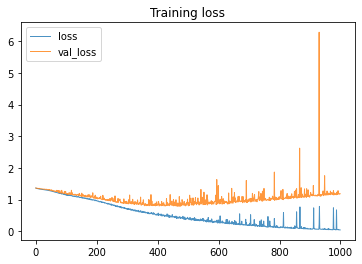

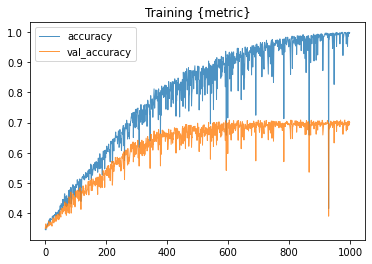

In [64]:
%%time
# No pre-training
model = torch.nn.Sequential(
    torch.nn.Linear(p, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 4),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()
train_eval_model(model, optimizer, loss_func, ds_train, ds_test, metrics=['accuracy'], device_name='auto')

### Pre-training with aux dataset 1

Running on cuda...
Train accuracy 0.983
Test accuracy  0.675
CPU times: user 2min 3s, sys: 202 ms, total: 2min 3s
Wall time: 2min 3s


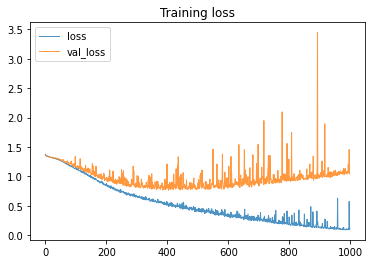

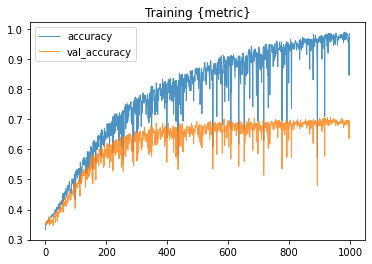

In [103]:
%%time
# Training with a pre-trained model 1 (frozen)
base_model = copy.deepcopy(model_1)
for param in base_model.parameters():
    param.requires_grad = False
model = torch.nn.Sequential(
    base_model[0],
    base_model[1],
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 4),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()
train_eval_model(model, optimizer, loss_func, ds_train, ds_test, metrics=['accuracy'], device_name='auto')

In [104]:
m = torch.nn.Sequential(
    base_model[0],
    base_model[1],
    base_model[2],
)
for p1, p2 in zip(model_1.parameters(), m.parameters()):
    print(torch.all(p1 == p2))

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')


Running on cuda...
Train accuracy 0.950
Test accuracy  0.678
CPU times: user 13 s, sys: 0 ns, total: 13 s
Wall time: 13 s


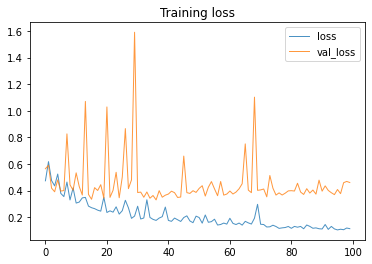

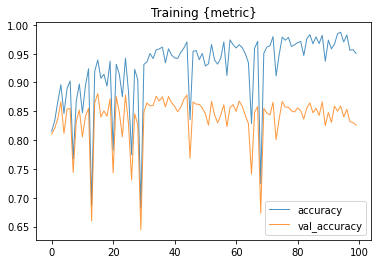

In [99]:
%%time
# Fine-tuning with a pre-trained model 1
for param in model.parameters():
    param.requires_grad = True
train_eval_model(model, optimizer, loss_func, ds_train, ds_test, metrics=['accuracy'], device_name='auto', n_epoch=100)

In [102]:
m = torch.nn.Sequential(
    base_model[0],
    base_model[1],
    base_model[2],
)
for p1, p2 in zip(model_1.parameters(), m.parameters()):
    print(torch.all(p1 == p2))

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')


Running on cuda...
Train accuracy 0.999
Test accuracy  0.708
CPU times: user 2min 4s, sys: 0 ns, total: 2min 4s
Wall time: 2min 4s


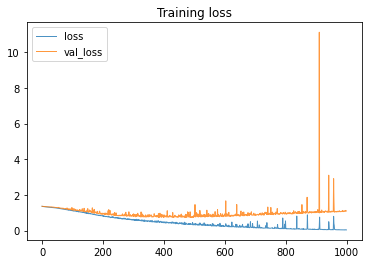

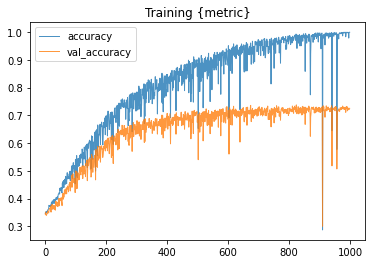

In [69]:
%%time
# Training with a pre-trained model 1 (trainable)
base_model = copy.deepcopy(model_1)
model = torch.nn.Sequential(
    base_model[0],
    base_model[1],
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 4),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_func = torch.nn.CrossEntropyLoss()
train_eval_model(model, optimizer, loss_func, ds_train, ds_test, metrics=['accuracy'], device_name='auto')

In [ ]:
%%time
# Shared parameters with aux model 1
# TODO: finish

